In [1]:
import numpy as np
import pickle
import matplotlib
import matplotlib.pyplot as plt
import tensorflow as tf
from models import RVAEModel, ClassModel, CRGANModel
from data_utils import DataFactory
from fastdtw import fastdtw
import fancyimpute
tf.enable_eager_execution()
%matplotlib inline

/home/malzantot/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/malzantot/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/malzantot/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/malzantot/anaconda3/lib/python3.6/site-packages/tensorflow/python/f

In [2]:
import impute_utils

In [3]:
CHECKPOINT_DIR = './save/ecg_physgan/07_27_21_11'
#CHECKPOINT_DIR = './save/ecg_crvae/07_29_13_10' #CVRAE
#CHECKPOINT_DIR = './save/ecg_crnn/08_12_21_18'
AUX_CHECKPOINT_DIR = './save/ecg_long_lstm/07_30_21_11'


In [4]:
ecg_train, ecg_test, metadata = DataFactory.create_dataset('ecg_long')
train_x, train_y = next(iter(ecg_train.shuffle(1000).batch(200)))
train_x = train_x.numpy()
train_y = train_y.numpy()

['1 NSR', '4 AFIB']
['1 NSR', '4 AFIB']
(array([0, 1], dtype=int32), array([211, 102]))
['1 NSR', '4 AFIB']
['1 NSR', '4 AFIB']
(array([0, 1], dtype=int32), array([72, 33]))


In [5]:

model = RVAEModel(enc_rnn_units=128,z_dim=8,dec_rnn_units=128,num_feats=metadata.num_feats,num_labels=metadata.num_labels)
#model = CRGANModel(num_feats=1,num_labels=2,z_dim=8,num_units=128)

aux_model = ClassModel(num_feats=1,num_labels=2)

W0813 22:41:17.717052 139952128886592 deprecation_wrapper.py:119] From /home/malzantot/Nesl/bio_gan/models.py:103: The name tf.keras.layers.CuDNNGRU is deprecated. Please use tf.compat.v1.keras.layers.CuDNNGRU instead.



In [6]:
checkpoint = tf.train.Checkpoint(model=model)
status = checkpoint.restore(tf.train.latest_checkpoint(CHECKPOINT_DIR))

aux_checkpoint = tf.train.Checkpoint(model=aux_model)
aux_checkpoint.restore(tf.train.latest_checkpoint(AUX_CHECKPOINT_DIR))

### Prepare data

In [7]:
data_file = 'test_ecg_segment.pkl' # Set this to None, to generate a new test set

mask_type = 'segment'
mask_prob = 0.25
test_size=200

if data_file is None:
    test_x, test_y, test_masks, test_masked = impute_utils.get_testset(ecg_test,
                                                      mask_type=mask_type,
                                                      mask_prob=mask_prob,
                                                      test_size=test_size)
else:
    test_x, test_y, test_masks, test_masked = impute_utils.get_data_from_pickle(data_file)
print(test_masks.shape)

(105, 120, 1)


In [8]:
accuracy_complete = impute_utils.evaluate_accuracy(aux_model, test_x, test_y)
print("Accuracy of complete data = {:.2f}".format(accuracy_complete))
accuracy_incomplete = impute_utils.evaluate_accuracy(aux_model, test_masked, test_y)
print('Accuracy of incomplete data = {:.2f}'.format(accuracy_incomplete))

W0813 22:41:19.294674 139952128886592 deprecation.py:323] From /home/malzantot/Nesl/bio_gan/impute_utils.py:102: arg_max (from tensorflow.python.ops.gen_math_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use `tf.math.argmax` instead


Accuracy of complete data = 0.99
Accuracy of incomplete data = 0.69


### Imputation code

In [9]:
def impute_mice(train_x, train_y, test_x, test_y, test_masks):
    x_incomplete = np.r_[ test_x, train_x]
    y_incomplete = np.r_[ test_y, train_y]
    x_mice = fancyimpute.MICE(n_imputations=100, n_pmm_neighbors=20, verbose=False).complete(x_incomplete[:,:,0])
    return x_mice[:test_x.shape[0],:,np.newaxis]

In [10]:
def impute_knn(train_x, train_y, test_x, test_y, test_masks):
    x_incomplete = np.r_[ test_x, train_x]
    y_incomplete = np.r_[ test_y, train_y]
    #knn_impute = #fancyimpute.KNN(k=10, verbose=True)
    #x_knn = knn_impute.fit_transform(x_incomplete[:,:,0],y=y_incomplete)
    x_knn = fancyimpute.KNN(k=10,verbose=True).complete(x_incomplete[:,:,0])
    return x_knn[:test_x.shape[0],:,np.newaxis]

In [11]:
def impute_physgan(train_x, train_y, test_x, test_y, test_masks):
    impute_outputs = []
    for i, (x_mask, x_in, x_label) in enumerate(zip(test_masks, test_x, test_y)):
        x_in_tf = tf.convert_to_tensor([np.nan_to_num(x_in)])
        x_label = x_label.reshape((-1,))
        x_mask = np.nan_to_num(x_mask)
        impute_result = model.impute(x_in_tf, x_label, x_mask).numpy()
        impute_outputs.append(impute_result[0])
    return np.array(impute_outputs)

In [12]:
impute_methods = {'mice': impute_mice, 'knn':impute_knn, 'physgan':impute_physgan}

## Actual experiments

In [13]:
methods = ['mice', 'knn', 'physgan']
result = {}
for m in methods:
    print('Trying {}'.format(m))
    m_complete = impute_methods[m](train_x, train_y, test_masked, test_y, test_masks)
    result[m] = m_complete

Trying mice


W0813 22:42:53.093763 139952128886592 deprecation_wrapper.py:119] From /home/malzantot/Nesl/bio_gan/models.py:112: The name tf.random_normal is deprecated. Please use tf.random.normal instead.



Trying knn
Imputing row 1/305 with 30 missing, elapsed time: 0.069
Imputing row 101/305 with 30 missing, elapsed time: 0.110
Imputing row 201/305 with 0 missing, elapsed time: 0.112
Imputing row 301/305 with 0 missing, elapsed time: 0.112
Trying physgan


### Evaluation

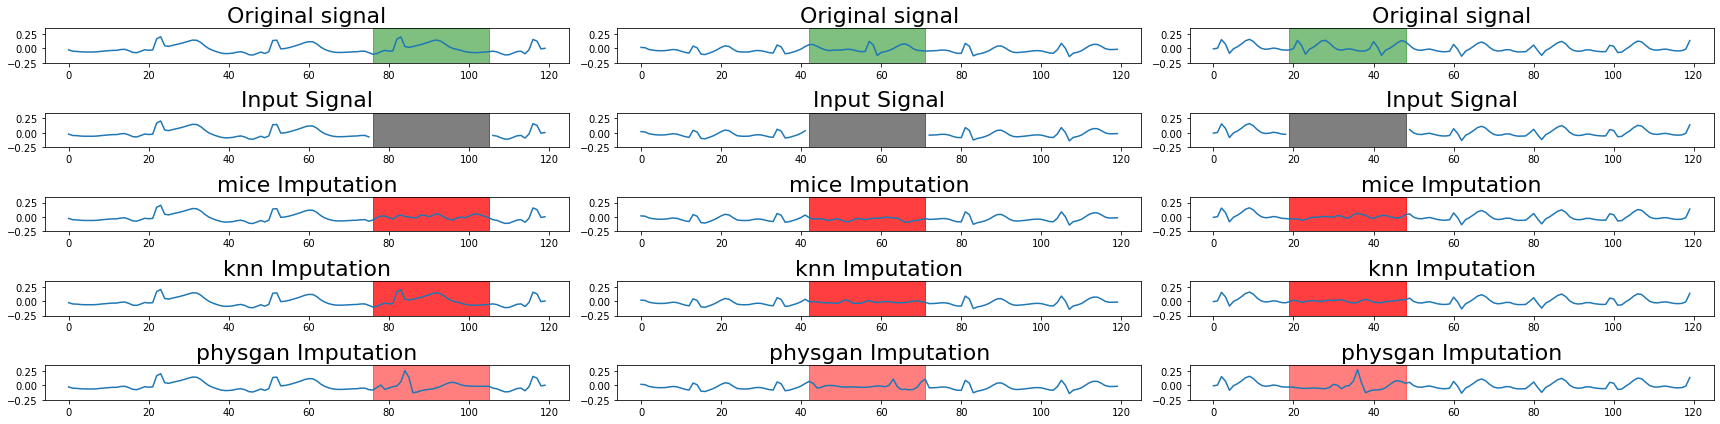

In [14]:
results_fig = impute_utils.plot_results(test_masked, test_x, test_masks, result, mask_type)
None

### Compute metrics

In [15]:
for i, m in enumerate(result.keys()):
    mae_score = impute_utils.evaluate_mae(test_x, result[m], test_masks)
    sem_score = impute_utils.evaluate_semantic(aux_model, test_x, test_y, test_masked, result[m])
    
    print('{} ::  MAE = {:.3f}  ::   Semantic = {:.3f}'.format(m, mae_score, sem_score))

mice ::  MAE = 0.056  ::   Semantic = 0.812
knn ::  MAE = 0.049  ::   Semantic = 0.812
physgan ::  MAE = 0.066  ::   Semantic = 0.875
